# Conformal Methods: Width–Coverage (per process) + Mean Runtime (across processes)

This notebook is a mildly adjusted copy of Stocker, Massimo's notebook, which can be found at the following [link](https://github.com/massicy2004-arch/Conformal-forecasting-notebook/tree/bf078f92897d166b5530a0d130480b020bfd29ae). 

The original notebook simulates **three** processes (AR(1), ARMA(1,1), Mean-Shift),
runs several conformal methods (SCP, WCP variants, ACI, EnbPI), and produces:

- One **scatter per process**: coverage vs. average interval width (markers = methods/params).
- One **runtime bar chart**: *mean runtime across the three processes* (averaged over Monte Carlo runs).

We have adjusted the notebook by adding GARCH(1,1) as a fourth process, as well as producing plots with error bars. Error bars are generated using a confidence interval of 95%.

The base forecaster is **ARL** (linear autoregression with fixed lag order `p=3`).
Plots use matplotlib only and a single chart per figure (per the constraints).

In [10]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
from time import perf_counter

rng = np.random.default_rng(12345)

# ---------- Simulation ----------
def simulate_ar1(n, phi=0.6, sigma=1.0, seed=None):
    r = np.random.default_rng(seed)
    y = np.zeros(n)
    eps = r.normal(0, sigma, size=n)
    for t in range(1, n):
        y[t] = phi * y[t-1] + eps[t]
    return y

def simulate_arma11(n, phi=0.5, theta=0.4, sigma=1.0, seed=None):
    r = np.random.default_rng(seed)
    y = np.zeros(n)
    eps = r.normal(0, sigma, size=n)
    for t in range(1, n):
        mae = eps[t-1] if t-1 >= 0 else 0.0
        y[t] = phi * y[t-1] + eps[t] + theta * mae
    return y

def simulate_mean_shift(n, shift_start, delta=1.0, sigma=1.0, seed=None):
    r = np.random.default_rng(seed)
    base = r.normal(0, sigma, size=n)
    y = base.copy()
    y[shift_start:] += delta
    # Add a small AR(1) component to keep some local dependence
    phi = 0.3
    for t in range(1, n):
        y[t] = phi*y[t-1] + (1.0-phi)*y[t]
    return y

# ---------- ARL base forecaster (p=3 by default) ----------
def build_design(y, p=3):
    # returns (X, target) using past p lags for autoregression with intercept
    n = len(y)
    if n <= p:
        raise ValueError("Not enough points for lagged design.")
    X = []
    target = []
    for t in range(p, n):
        X.append([1.0] + [y[t-k] for k in range(1, p+1)])  # intercept + lags
        target.append(y[t])
    return np.asarray(X), np.asarray(target)

def fit_ar_ols(y, p=3):
    X, target = build_design(y, p=p)
    beta, *_ = np.linalg.lstsq(X, target, rcond=None)
    return beta  # beta[0]=intercept, beta[1:]=lags

def predict_next(beta, y_hist, p=3):
    # y_hist: array-like with most recent value at index -1.
    if len(y_hist) < p:
        return y_hist[-1]  # fallback
    x = np.array([1.0] + [y_hist[-k] for k in range(1, p+1)])
    return float(x @ beta)

# ---------- Quantiles ----------
def weighted_quantile(values, quantile, sample_weight=None):
    values = np.asarray(values, dtype=float)
    if sample_weight is None:
        return np.quantile(values, quantile, method="linear")
    w = np.asarray(sample_weight, dtype=float)
    assert values.shape[0] == w.shape[0]
    sorter = np.argsort(values)
    v = values[sorter]
    w = w[sorter]
    cdf = np.cumsum(w) / np.sum(w)
    return float(np.interp(quantile, cdf, v))

# ---------- Methods ----------
def method_SCP(y, n_train, n_cal, n_test, alpha=0.1, p=3):
    # Train on first n_train; calibrate on next n_cal; predict next n_test
    beta = fit_ar_ols(y[:n_train], p=p)
    # Build residuals on calibration
    cal_series = y[:n_train + n_cal]
    preds_cal = []
    for t in range(n_train, n_train + n_cal):
        y_hist = cal_series[:t]  # up to t-1
        preds_cal.append(predict_next(beta, y_hist, p=p))
    eps_cal = np.abs(y[n_train:n_train+n_cal] - np.array(preds_cal))
    q = np.quantile(eps_cal, 1-alpha, method="linear")
    # Predict intervals on test
    intervals = []
    preds_test = []
    for t in range(n_train + n_cal, n_train + n_cal + n_test):
        y_hist = y[:t]
        mu = predict_next(beta, y_hist, p=p)
        intervals.append((mu - q, mu + q))
        preds_test.append(mu)
    intervals = np.array(intervals)
    cov = np.mean((y[n_train+n_cal:n_train+n_cal+n_test] >= intervals[:,0]) &
                  (y[n_train+n_cal:n_train+n_cal+n_test] <= intervals[:,1]))
    width = np.mean(intervals[:,1] - intervals[:,0])
    return cov, width

def method_WCP(y, n_train, n_cal, n_test, alpha=0.1, p=3, scheme="exp", rho=0.99, W=50):
    beta = fit_ar_ols(y[:n_train], p=p)
    cal_series = y[:n_train + n_cal]
    preds_cal = []
    for t in range(n_train, n_train + n_cal):
        preds_cal.append(predict_next(beta, cal_series[:t], p=p))
    eps_cal = np.abs(y[n_train:n_train+n_cal] - np.array(preds_cal))
    # weights (index from oldest=1 to newest=n_cal)
    idx = np.arange(1, n_cal+1)
    if scheme == "exp":
        w = rho**(n_cal - idx)
    elif scheme == "linear":
        w = idx
    elif scheme == "window":
        w = (idx > (n_cal - W)).astype(float)
    else:
        w = np.ones_like(idx, dtype=float)
    # include test weight 1 in normalization (per WCP design); here we only need eps quantile
    q = weighted_quantile(eps_cal, 1-alpha, sample_weight=w)
    # test intervals
    intervals = []
    for t in range(n_train + n_cal, n_train + n_cal + n_test):
        mu = predict_next(beta, y[:t], p=p)
        intervals.append((mu - q, mu + q))
    intervals = np.array(intervals)
    cov = np.mean((y[n_train+n_cal:n_train+n_cal+n_test] >= intervals[:,0]) &
                  (y[n_train+n_cal:n_train+n_cal+n_test] <= intervals[:,1]))
    width = np.mean(intervals[:,1] - intervals[:,0])
    return cov, width

def method_ACI(y, n_train, n_cal, n_test, alpha=0.1, gamma=0.005, p=3):
    beta = fit_ar_ols(y[:n_train], p=p)
    # init residual pool from calibration
    cal_series = y[:n_train + n_cal]
    preds_cal = []
    for t in range(n_train, n_train + n_cal):
        preds_cal.append(predict_next(beta, cal_series[:t], p=p))
    eps_pool = deque(np.abs(y[n_train:n_train+n_cal] - np.array(preds_cal)).tolist())
    # online
    alpha_t = alpha
    intervals = []
    preds_test = []
    for t in range(n_train + n_cal, n_train + n_cal + n_test):
        q = np.quantile(np.array(eps_pool), 1 - alpha_t, method="linear")
        mu = predict_next(beta, y[:t], p=p)
        intervals.append((mu - q, mu + q))
        preds_test.append(mu)
        # observe Y_t and update
        err = alpha - (0 if (y[t] >= mu - q and y[t] <= mu + q) else 1)
        alpha_t = np.clip(alpha_t + gamma * err, 1e-6, 1-1e-6)
        # update residual pool with |Y_t - mu|, pop oldest to keep size fixed
        eps_pool.append(abs(y[t] - mu))
        eps_pool.popleft()
    intervals = np.array(intervals)
    cov = np.mean((y[n_train+n_cal:n_train+n_cal+n_test] >= intervals[:,0]) &
                  (y[n_train+n_cal:n_train+n_cal+n_test] <= intervals[:,1]))
    width = np.mean(intervals[:,1] - intervals[:,0])
    return cov, width

def method_EnbPI(y, T, n_test, alpha=0.1, B=25, s=10, p=3):
    # Training window is y[:T]. Build B bootstrap AR models.
    n = len(y)
    idx = np.arange(T)
    # fit B models
    models = []
    boots = []
    for b in range(B):
        S_b = rng.choice(idx, size=T, replace=True)
        boots.append(S_b)
        beta_b = fit_ar_ols(y[S_b], p=p)
        models.append(beta_b)
    # Build OOB residuals for indices p..T-1
    eps = []
    for i in range(p, T):
        O_i = [b for b, S_b in enumerate(boots) if i not in S_b]
        if len(O_i)==0:
            preds = [models[b] for b in range(B)]
            mu_i = np.mean([predict_next(models[b], y[:i], p=p) for b in range(B)])
        else:
            mu_i = np.mean([predict_next(models[b], y[:i], p=p) for b in O_i])
        eps.append(abs(y[i] - mu_i))
    eps = deque(eps)  # sliding residual window (size ~ T-p)

    # Predict on test points sequentially
    intervals = []
    pending = []  # store (t, mu_t) awaiting reveal in batches of size s
    for t in range(T, T + n_test):
        mu_t = np.mean([predict_next(models[b], y[:t], p=p) for b in range(B)])
        q = np.quantile(np.array(list(eps)), 1-alpha, method="linear")
        intervals.append((mu_t - q, mu_t + q))
        pending.append((t, mu_t))
        # reveal every s steps
        if (t - T + 1) % s == 0:
            for (tt, mu_pred) in pending:
                eps.append(abs(y[tt] - mu_pred))
                # keep window roughly constant length by dropping from left
                if len(eps) > (T - p):
                    eps.popleft()
            pending = []
    intervals = np.array(intervals)
    cov = np.mean((y[T:T+n_test] >= intervals[:,0]) & (y[T:T+n_test] <= intervals[:,1]))
    width = np.mean(intervals[:,1] - intervals[:,0])
    return cov, width


#### Additional GARCH(1,1) Model and Error Bars Functions

In [11]:
from scipy import stats

def simulate_garch(n, omega=0.3, alpha=0.5, beta=0.1, sigma=1.0, seed=None):
  # for a heteroskedastic (non-constant variance) error term
  r = np.random.default_rng(seed)
  y = np.zeros(n)
  eps = r.normal(0, sigma, size=n)
  for t in range(1, n):
    y[t] = eps[t] * np.sqrt(omega + (alpha * y[t-1]**2) + (beta * sigma**2))
  return y

# ---------- Error Bars -------
def error_bars_confidence(mean, std, n, confidence):
  df = n-1
  tsc = stats.t.ppf(1 - confidence/2, df)
  lol = std / np.sqrt(n+1)
  res = tsc * lol
  return res

def error_bars_prediction(mean, std, n, confidence):
  df = n-1
  tsc = stats.t.ppf(1 - confidence/2, df)
  res = tsc * std
  return res

In [12]:

# ---------- Experiment settings ----------
n_total = 900
n_train = 300
n_cal   = 300
n_test  = 300
alpha   = 0.10
p_lags  = 3
B_boot  = 25
batch_sizes = [1, 10, 100]
gammas = [0.001, 0.005, 0.01]
wcp_schemes = [("WCP-exp", {"scheme":"exp","rho":0.99}),
               ("WCP-linear", {"scheme":"linear"}),
               ("WCP-window", {"scheme":"window","W":50})]

N_MC = 50  # Monte Carlo repetitions

processes = [
    ("AR(1)", lambda seed: simulate_ar1(n_total, phi=0.6, sigma=1.0, seed=seed)),
    ("ARMA(1,1)", lambda seed: simulate_arma11(n_total, phi=0.5, theta=0.4, sigma=1.0, seed=seed)),
    ("Mean-Shift", lambda seed: simulate_mean_shift(n_total, shift_start=n_train + n_cal//2, delta=1.0, sigma=1.0, seed=seed)),
    ("GARCH(1,1)", lambda seed: simulate_garch(n_total, omega=0.3, alpha=0.5, beta=0.1, sigma=1.0, seed=seed))
]


In [13]:

rows = []

for proc_name, gen in processes:
    for run in range(N_MC):
        seed = 10_000 + 100*run
        y = gen(seed)

        # ----- SCP -----
        t0 = perf_counter()
        cov, wid = method_SCP(y, n_train, n_cal, n_test, alpha=alpha, p=p_lags)
        rt = perf_counter() - t0
        rows.append({"process": proc_name, "method": "SCP", "param": "",
                     "coverage": cov, "width": wid, "runtime": rt})

        # ----- WCP variants -----
        for label, kwargs in wcp_schemes:
            t0 = perf_counter()
            cov, wid = method_WCP(y, n_train, n_cal, n_test, alpha=alpha, p=p_lags, **kwargs)
            rt = perf_counter() - t0
            rows.append({"process": proc_name, "method": label, "param": "",
                         "coverage": cov, "width": wid, "runtime": rt})

        # ----- ACI (three gammas) -----
        for g in gammas:
            t0 = perf_counter()
            cov, wid = method_ACI(y, n_train, n_cal, n_test, alpha=alpha, gamma=g, p=p_lags)
            rt = perf_counter() - t0
            rows.append({"process": proc_name, "method": "ACI", "param": f"gamma={g}",
                         "coverage": cov, "width": wid, "runtime": rt})

        # ----- EnbPI (three batch sizes) -----
        T_window = n_train + n_cal
        for s in batch_sizes:
            t0 = perf_counter()
            cov, wid = method_EnbPI(y, T_window, n_test, alpha=alpha, B=B_boot, s=s, p=p_lags)
            rt = perf_counter() - t0
            rows.append({"process": proc_name, "method": "EnbPI", "param": f"s={s}",
                         "coverage": cov, "width": wid, "runtime": rt})

results = pd.DataFrame(rows)
results_head = results.head(10)
results_head


,process,method,param,coverage,width,runtime
0,AR(1),SCP,,0.900000,3.248716,0.002858
1,AR(1),WCP-exp,,0.896667,3.155067,0.002036
2,AR(1),WCP-linear,,0.896667,3.185017,0.001876
3,AR(1),WCP-window,,0.896667,3.151807,0.001895
4,AR(1),ACI,gamma=0.001,0.890000,3.121778,0.026269
5,AR(1),ACI,gamma=0.005,0.896667,3.085247,0.026586
6,AR(1),ACI,gamma=0.01,0.893333,3.149332,0.025216
7,AR(1),EnbPI,s=1,0.880000,4.128231,0.128044
8,AR(1),EnbPI,s=10,0.870000,4.038402,0.124639
9,AR(1),EnbPI,s=100,0.873333,4.082215,0.122342


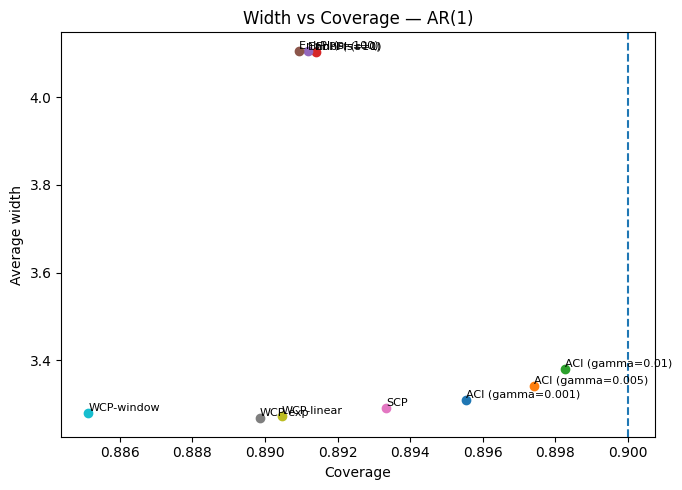

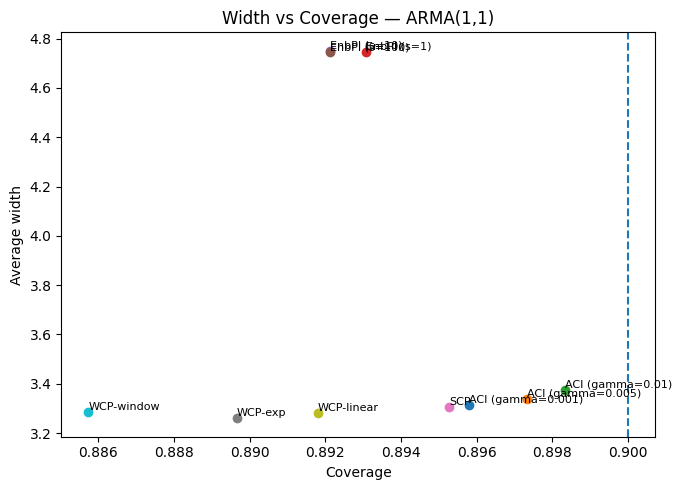

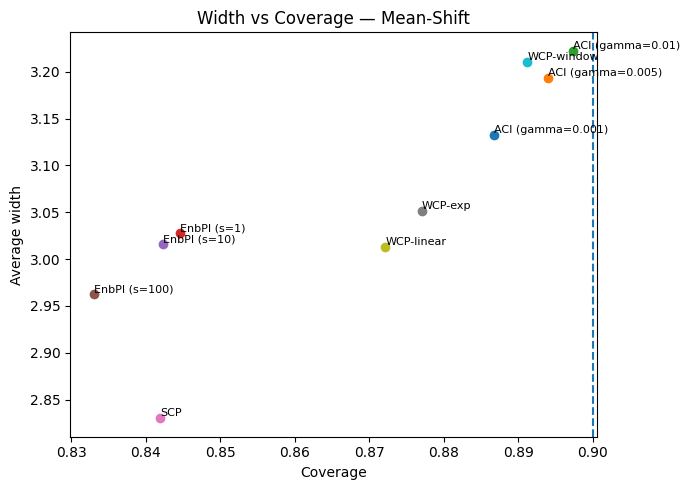

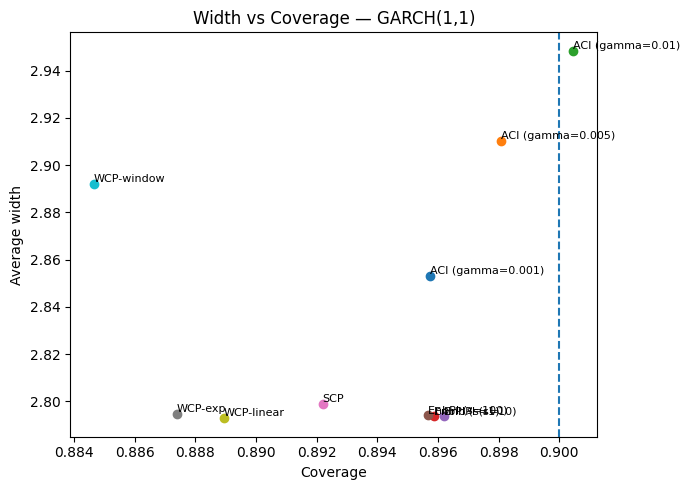

In [14]:

# One scatter per process: coverage vs average width
for proc_name in results["process"].unique():
    dfp = results[results["process"] == proc_name].copy()
    # aggregate over MC runs (mean coverage/width per method+param)
    agg = dfp.groupby(["method","param"], as_index=False)[["coverage","width"]].mean()

    plt.figure(figsize=(7,5))
    for _, row in agg.iterrows():
        label = row["method"] if row["param"]=="" else f'{row["method"]} ({row["param"]})'
        plt.scatter(row["coverage"], row["width"], label=label)
        # small text for readability
        plt.text(row["coverage"], row["width"], label, fontsize=8, ha="left", va="bottom")
    plt.axvline(1 - alpha, linestyle="--")
    plt.title(f"Width vs Coverage — {proc_name}")
    plt.xlabel("Coverage")
    plt.ylabel("Average width")
    plt.tight_layout()
    plt.savefig(f"{proc_name}-SIMPLE")
    plt.show()


#### Adjusted Plots for Smaller Amount of Whitespace + Error Bars

C:\Users\Wiktoria\AppData\Local\Temp\ipykernel_9244\1646678978.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  res = dfp[(dfp['method'] == method[1][0]) & (dfp['param'] == method[1][1])]


       method        param  coverage     width   cov_err  width_err
0         ACI  gamma=0.001  0.895533  3.309920  0.006997   0.048032
1         ACI  gamma=0.005  0.897400  3.342550  0.008739   0.059622
2         ACI   gamma=0.01  0.898267  3.379750  0.007935   0.055423
3       EnbPI          s=1  0.891400  4.103613  0.015040   0.123052
4       EnbPI         s=10  0.891200  4.104628  0.003995   0.029668
5       EnbPI        s=100  0.890933  4.105772  0.002533   0.029894
6         SCP               0.893333  3.290719  0.001897   0.034620
7     WCP-exp               0.889867  3.267722  0.005495   0.047844
8  WCP-linear               0.890467  3.272919  0.005361   0.047744
9  WCP-window               0.885133  3.280326  0.006387   0.052875


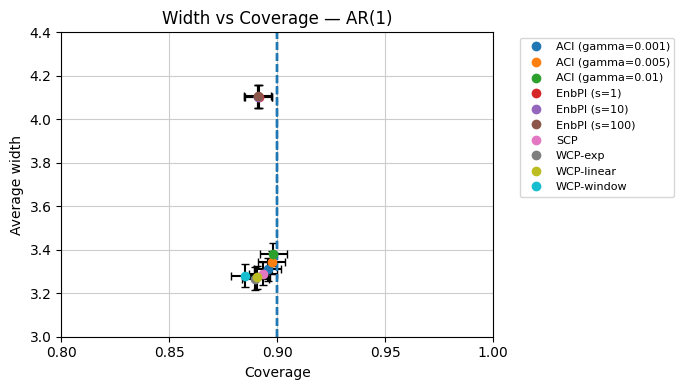

       method        param  coverage     width   cov_err  width_err
0         ACI  gamma=0.001  0.895800  3.313632  0.007168   0.048577
1         ACI  gamma=0.005  0.897333  3.337893  0.008523   0.059596
2         ACI   gamma=0.01  0.898333  3.373550  0.007917   0.056724
3       EnbPI          s=1  0.893067  4.746317  0.014729   0.120350
4       EnbPI         s=10  0.892133  4.751010  0.003943   0.030471
5       EnbPI        s=100  0.892133  4.745786  0.002640   0.030313
6         SCP               0.895267  3.304415  0.001934   0.033389
7     WCP-exp               0.889667  3.259826  0.005269   0.057390
8  WCP-linear               0.891800  3.282088  0.005410   0.058554
9  WCP-window               0.885733  3.285284  0.006249   0.061595


C:\Users\Wiktoria\AppData\Local\Temp\ipykernel_9244\1646678978.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  res = dfp[(dfp['method'] == method[1][0]) & (dfp['param'] == method[1][1])]


<Figure size 700x400 with 0 Axes>

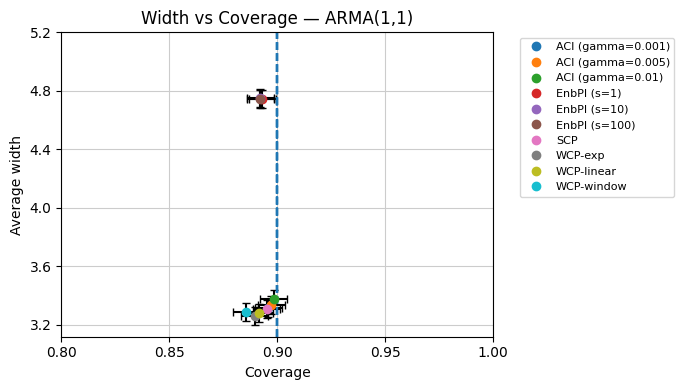

C:\Users\Wiktoria\AppData\Local\Temp\ipykernel_9244\1646678978.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  res = dfp[(dfp['method'] == method[1][0]) & (dfp['param'] == method[1][1])]


       method        param  coverage     width   cov_err  width_err
0         ACI  gamma=0.001  0.886733  3.132603  0.008384   0.057248
1         ACI  gamma=0.005  0.894000  3.193531  0.008786   0.073425
2         ACI   gamma=0.01  0.897400  3.222514  0.008005   0.065280
3       EnbPI          s=1  0.844667  3.027705  0.015626   0.121800
4       EnbPI         s=10  0.842267  3.015619  0.004091   0.052859
5       EnbPI        s=100  0.833067  2.962727  0.002366   0.053804
6         SCP               0.841933  2.829981  0.001783   0.053716
7     WCP-exp               0.877067  3.051077  0.006253   0.031350
8  WCP-linear               0.872133  3.012560  0.006293   0.032090
9  WCP-window               0.891200  3.210307  0.007109   0.031592


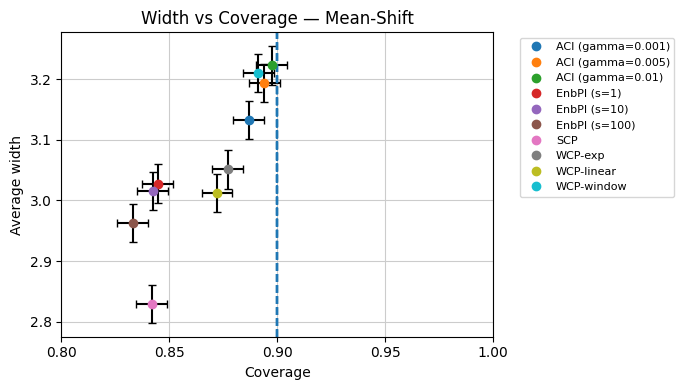

C:\Users\Wiktoria\AppData\Local\Temp\ipykernel_9244\1646678978.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  res = dfp[(dfp['method'] == method[1][0]) & (dfp['param'] == method[1][1])]


       method        param  coverage     width   cov_err  width_err
0         ACI  gamma=0.001  0.895733  2.853044  0.008059   0.055414
1         ACI  gamma=0.005  0.898067  2.910258  0.011118   0.102670
2         ACI   gamma=0.01  0.900467  2.948427  0.009674   0.082982
3       EnbPI          s=1  0.895867  2.793754  0.016513   0.196784
4       EnbPI         s=10  0.896200  2.793709  0.004607   0.050270
5       EnbPI        s=100  0.895667  2.794212  0.003485   0.055805
6         SCP               0.892200  2.798957  0.002613   0.068745
7     WCP-exp               0.887400  2.794806  0.005799   0.035336
8  WCP-linear               0.888933  2.792823  0.005603   0.035310
9  WCP-window               0.884667  2.892105  0.006053   0.035172


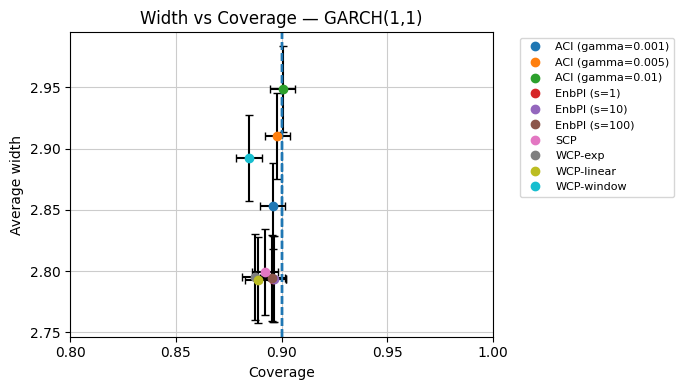

In [15]:
from matplotlib import container

for proc_name in results["process"].unique():
  dfp = results[results["process"] == proc_name].copy()
  # aggregate over MC runs (mean coverage/width per method+param)
  agg = dfp.groupby(["method","param"], as_index=False)[["coverage","width"]].mean()

  if proc_name == 'AR(1)' or 'Mean-Shift':
    plt.figure(figsize=(7,4))
  if proc_name == 'ARMA(1,1)':
    plt.figure(figsize=(7,4))

  unique_pairs = dfp[['method', 'param']].drop_duplicates()

  err = []
  for method in unique_pairs.iterrows():
    # 1. filter subsets for each method
    res = dfp[(dfp['method'] == method[1][0]) & (dfp['param'] == method[1][1])]

    # 2. for each subset, calc error bands
    cov_err = error_bars_confidence(np.mean(res['coverage']), np.std(res['coverage']), len(res), 0.05)
    width_err = error_bars_confidence(np.mean(res['width']), np.std(res['width']), len(res), 0.05)
    err.append([cov_err, width_err])

  # aggregate over MC runs (mean coverage/width per method+param)
  agg = dfp.groupby(["method","param"], as_index=False)[["coverage","width"]].mean()
  agg[['cov_err', 'width_err']] = err

  print(agg)

  for _, row in agg.iterrows():
    label = row["method"] if row["param"] == "" else f'{row["method"]} ({row["param"]})'
    
    plt.errorbar(
      row["coverage"], row["width"],
      width_err, cov_err,
      ecolor='black', capsize=3,fmt='o',
      label=label
    )

    ax = plt.gca()

    plt.axvline(1 - alpha, linestyle="--")
    plt.title(f"Width vs Coverage — {proc_name}")
    plt.grid(True, color="0.8")

  if proc_name == 'AR(1)':
    plt.yticks(np.arange(3, 4.4, 0.2))
  elif proc_name == 'ARMA(1,1)':
    plt.yticks(np.arange(3.2, 5.6, 0.4))

  plt.xlabel("Coverage")
  plt.ylabel("Average width")
  plt.xticks(np.arange(0.8, 1.05, 0.05))
  handles, labels = ax.get_legend_handles_labels()

  new_handles = []

  for h in handles:
    #only need to edit the errorbar legend entries
    if isinstance(h, container.ErrorbarContainer):
        new_handles.append(h[0])
    else:
        new_handles.append(h)

  ax.legend(new_handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
  plt.tight_layout()
  plt.savefig(f'{proc_name}.png')
  plt.show()

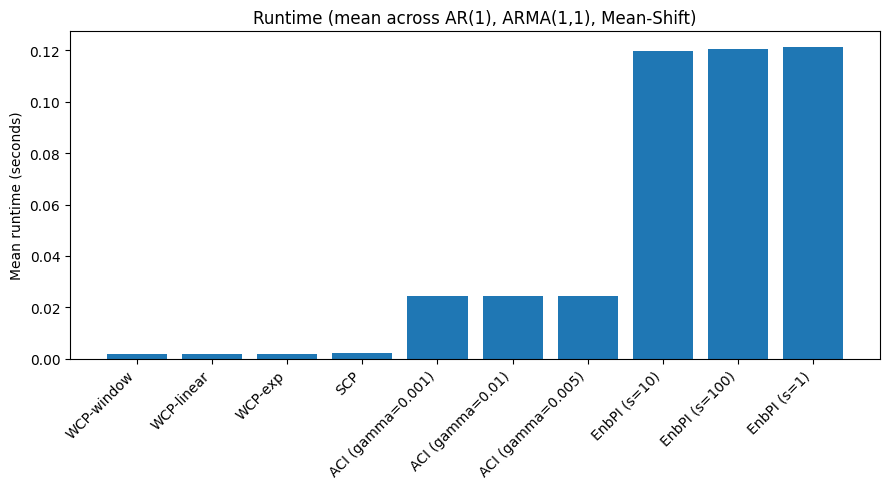

In [16]:

# Mean runtime across the three processes (and across MC runs)
# We aggregate per (method, param), then average over processes.
agg_proc = results.groupby(["process","method","param"], as_index=False)["runtime"].mean()
mean_over_processes = agg_proc.groupby(["method","param"], as_index=False)["runtime"].mean()
mean_over_processes["label"] = mean_over_processes.apply(
    lambda r: r["method"] if (r["param"]=="" or pd.isna(r["param"])) else f'{r["method"]} ({r["param"]})', axis=1
)

plt.figure(figsize=(9,5))
order = mean_over_processes.sort_values("runtime")["label"].tolist()
vals = mean_over_processes.set_index("label").loc[order]["runtime"].values
xpos = np.arange(len(order))
plt.bar(xpos, vals)
plt.xticks(xpos, order, rotation=45, ha="right")
plt.ylabel("Mean runtime (seconds)")
plt.title("Runtime (mean across AR(1), ARMA(1,1), Mean-Shift)")
plt.tight_layout()
plt.show()
